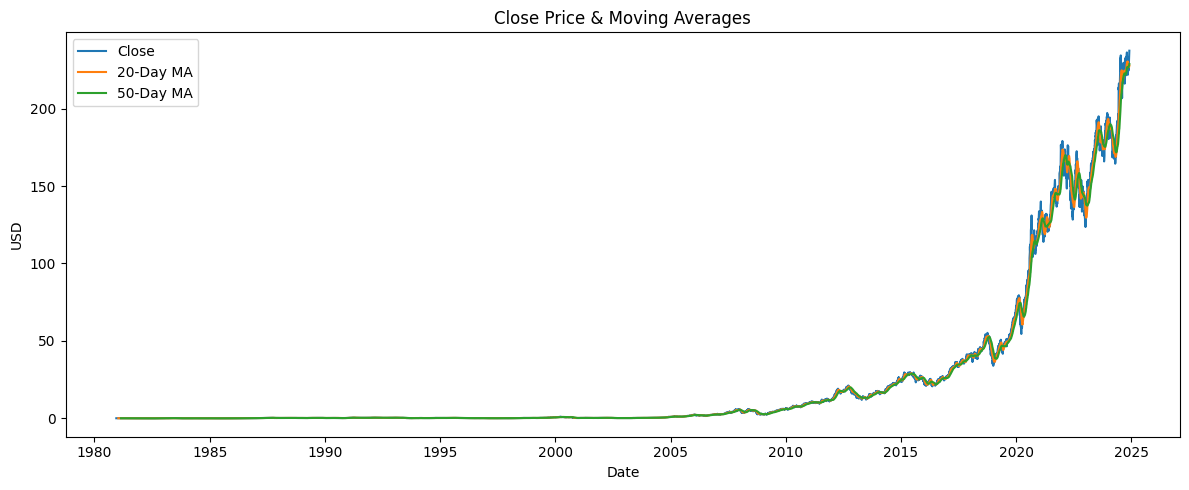

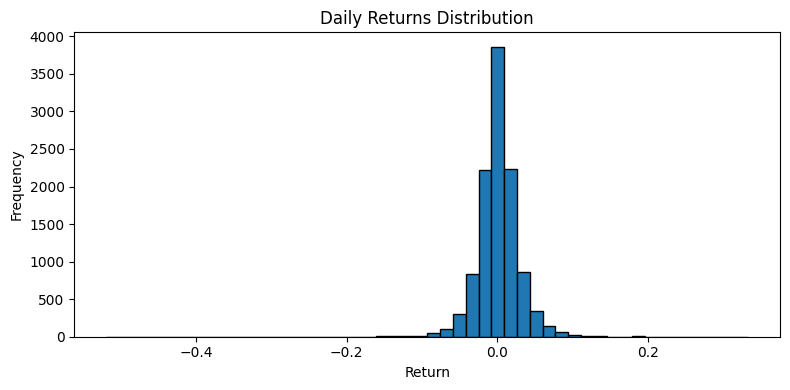

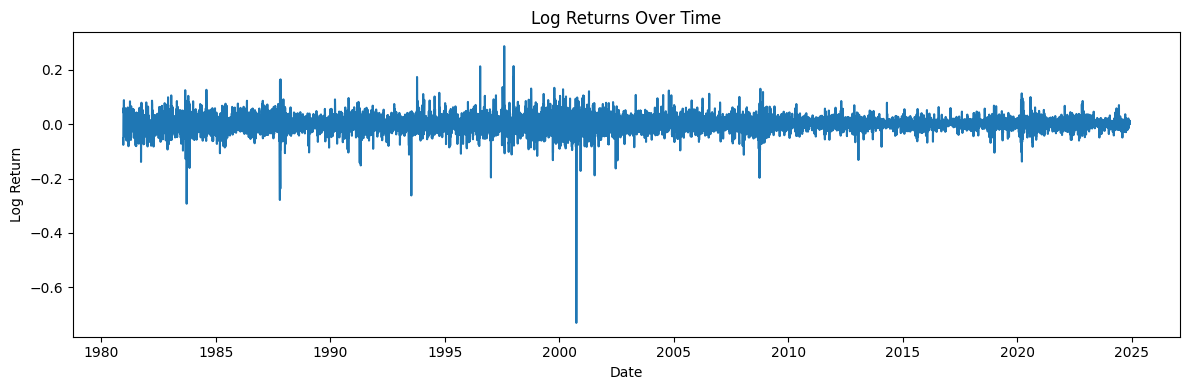

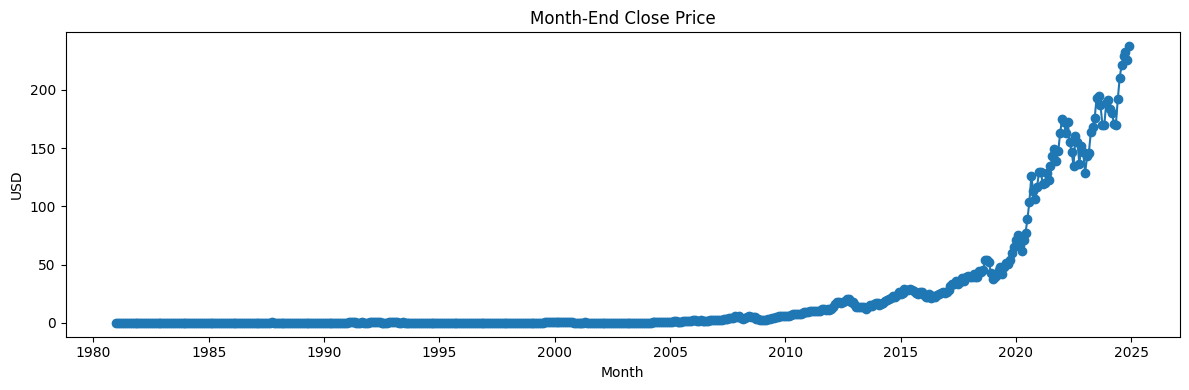

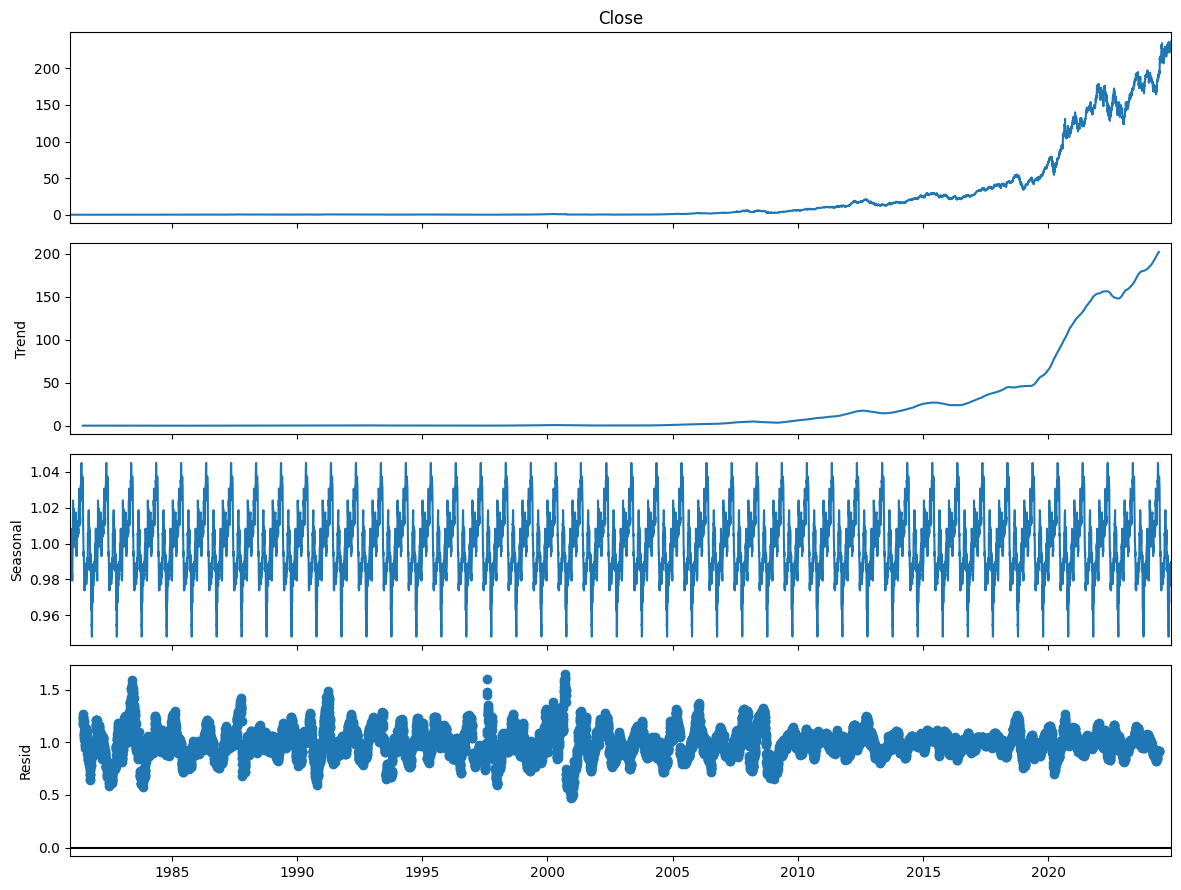

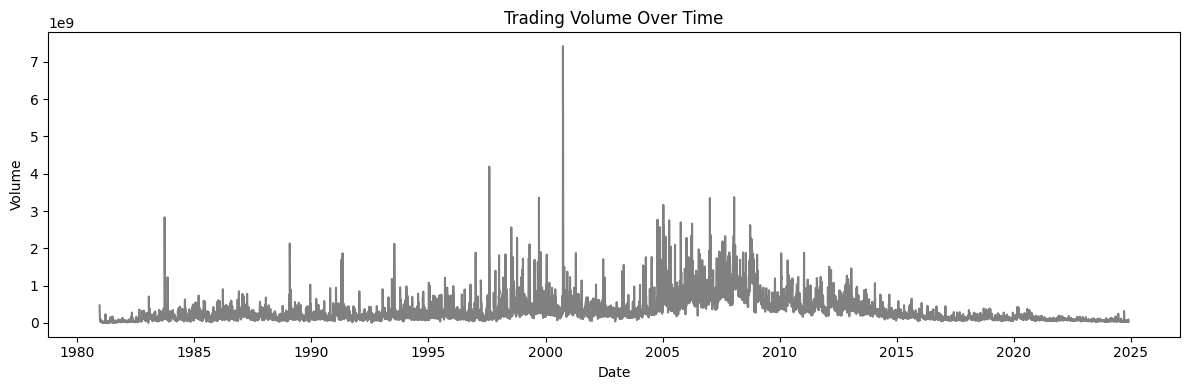

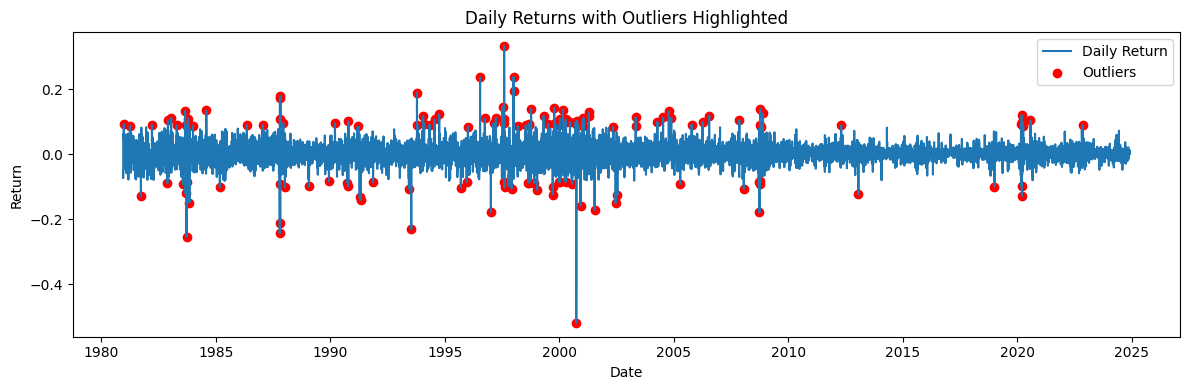

Preprocessed DataFrame head:
                         Open      High       Low     Close     Volume  MA20  \
Date                                                                           
1980-12-12 05:00:00  0.098834  0.099264  0.098834  0.098834  469033600   NaN   
1980-12-15 05:00:00  0.094108  0.094108  0.093678  0.093678  175884800   NaN   
1980-12-16 05:00:00  0.087232  0.087232  0.086802  0.086802  105728000   NaN   
1980-12-17 05:00:00  0.088951  0.089381  0.088951  0.088951   86441600   NaN   
1980-12-18 05:00:00  0.091530  0.091959  0.091530  0.091530   73449600   NaN   

                     MA50    Return  LogReturn  Return_Outlier  
Date                                                            
1980-12-12 05:00:00   NaN       NaN        NaN           False  
1980-12-15 05:00:00   NaN -0.052171  -0.053581           False  
1980-12-16 05:00:00   NaN -0.073398  -0.076231           False  
1980-12-17 05:00:00   NaN  0.024750   0.024449           False  
1980-12-18 05:00:00 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('apple_stock_dataset.csv')

df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce').dt.tz_convert(None)

# Dropping rows with invalid dates
df = df.dropna(subset=['Date'])

df = df.set_index('Date').sort_index()

# Imputation
# Forward-fill, backward-fill, then interpolate linearly to fill any remaining gaps
df = df.ffill().bfill()
df = df.interpolate(method='linear')

# Feature engineering
df['MA20']      = df['Close'].rolling(window=20).mean()
df['MA50']      = df['Close'].rolling(window=50).mean()
df['Return']    = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

# Outlier detection in returns
return_mean = df['Return'].mean()
return_std  = df['Return'].std()
outlier_cutoff = 3 * return_std

# Created a flag column for outliers
df['Return_Outlier'] = ((df['Return'] - return_mean).abs() > outlier_cutoff)

# Resample to month-end
monthly_close = df['Close'].resample('ME').last()

# Seasonal decomposition
decomp = seasonal_decompose(df['Close'], model='multiplicative', period=252)

# Plots

# A. Close price & MAs
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='20-Day MA')
plt.plot(df['MA50'], label='50-Day MA')
plt.title('Close Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.tight_layout()
plt.show()

# B. Histogram of daily returns
plt.figure(figsize=(8, 4))
plt.hist(df['Return'].dropna(), bins=50, edgecolor='black')
plt.title('Daily Returns Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# C. Log returns over time
plt.figure(figsize=(12, 4))
plt.plot(df['LogReturn'], label='Log Return')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.tight_layout()
plt.show()

# D. Monthly close price
plt.figure(figsize=(12, 4))
plt.plot(monthly_close, marker='o')
plt.title('Month-End Close Price')
plt.xlabel('Month')
plt.ylabel('USD')
plt.tight_layout()
plt.show()

# E. Seasonal decomposition components
fig = decomp.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
plt.show()

# F. Trading volume
if 'Volume' in df.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(df['Volume'], color='gray')
    plt.title('Trading Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.tight_layout()
    plt.show()

# G. Outlier flags plot
plt.figure(figsize=(12, 4))
plt.plot(df['Return'], label='Daily Return')
plt.scatter(df.index[df['Return_Outlier']],
            df.loc[df['Return_Outlier'], 'Return'],
            color='red', label='Outliers')
plt.title('Daily Returns with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()

# Final check
print("Preprocessed DataFrame head:")
print(df.head())

# Showing count of outliers detected
print(f"Number of daily return outliers detected: {df['Return_Outlier'].sum()}")
